In [1]:
# Build a Deep CNN Image Classifier with ANY Images - https://www.youtube.com/watch?v=jztwpsIzEGc&ab_channel=NicholasRenotte
# Any othere important comments here


In [2]:
#!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [3]:
#tf.compat.v1.enable_eager_execution()

In [4]:
import tensorflow as tf
import os

In [5]:
# Avoid OOM errors by setting GPU Memory Consumption Growth - Works only with Nvidia Graphics - 2022
# Prevent from geeting all GPU RAM's by tensorflow
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

1.2 Remove all Iamges with wrong extensions etc.

In [7]:
import cv2
import imghdr
import shutil

In [8]:
data_dir = 'data'

In [9]:
image_extensions = ['jpeg', 'jpg', 'bmp', 'png'] # List of available extensions

In [10]:
#tf.data.Dataset

In [11]:
import numpy as np
from matplotlib import pyplot as plt

In [12]:
# Loading Data - Create datasets with labels (subdirectory names). Split for n-counts of batches with size of 32 (default)
data = tf.keras.utils.image_dataset_from_directory('data_v2', image_size = (224,224), batch_size = 16) 

# It is working as Generator - do not loading files into memory
# Automaticly resize images - unified size of image 256x256 and create batches of images to maintain better prformance. 
# If our PC got not as much memory on GPU as it is needed, we can change size of batch ora change size of images 

Found 366 files belonging to 2 classes.


In [13]:
data_iterator = data.as_numpy_iterator() 

In [14]:
batch = data_iterator.next() # This line grab the batches from pipeline - again and again and again

In [15]:
# Images represented as numpy arrays
len(batch) # Print 2 - one for images in batches in te shape of numpy array
batch[0] # Print values from first position in batch
batch[0].shape # Show how many images are in a batch - in this case 32 it can be modified

(16, 224, 224, 3)

In [16]:
batch[1] # Labels of the images taken from directors contained in main directory

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0])

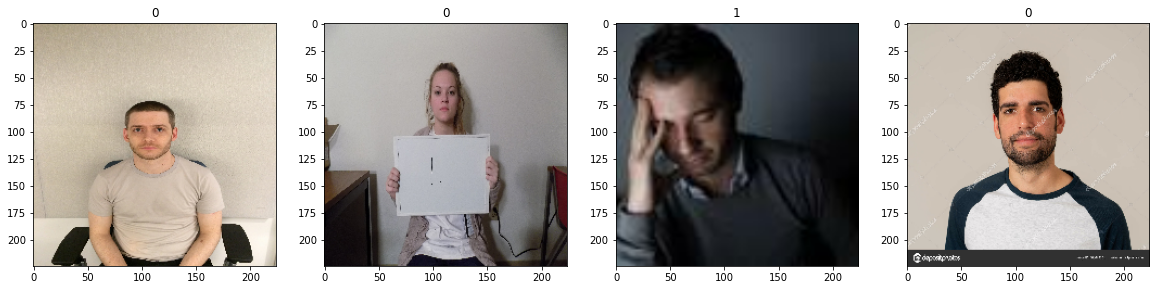

In [17]:
fig, ax = plt.subplots( ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

    # Quick check which label is for which picture. In this case 0 - happy, 1 - sad


2. Preprocess Data

2.1 Scale Data

In [18]:
data = data.map(lambda x,y: (x/255, y)) # Allows create transformation in pipline

In [19]:
scaled_iterator = data.as_numpy_iterator()

In [20]:
batch = scaled_iterator.next()

In [21]:
batch[0].min()

0.0

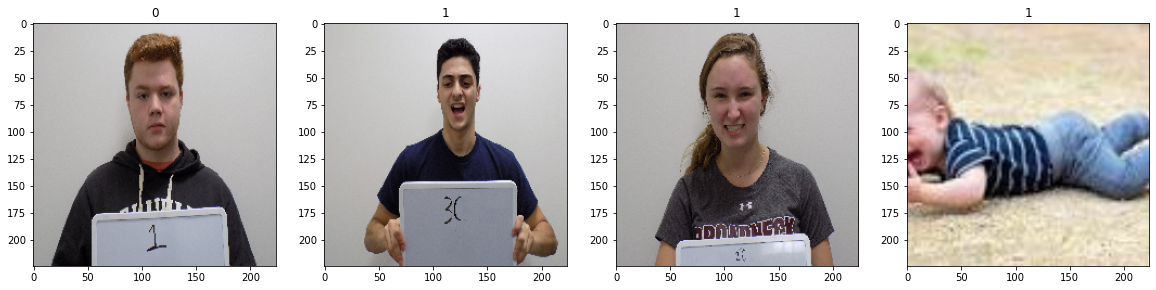

In [22]:
fig, ax = plt.subplots( ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

2.2 Split Data to Training and Testing 

In [23]:
len(data) # How many batches have we got. This example: 7 batches with 32 images each

23

In [24]:
# Split batches between training, validation and testing
# The sum of each has to equal the number of batches.
# In this case we got 7 batches: 4 for training, 2 for validation and 1 for testing.
train_size = int(len(data)*.7)-1
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)+1

# train and val data is used in trianing process. Training data allow us to trian deep learning network, validation is for model checking
# test batch is to check the results of training our network -> used at the end

In [25]:
train_size

15

In [26]:
val_size

5

In [27]:
test_size

3

In [28]:
batches_size = train_size + val_size + test_size

In [29]:
batches_size

23

In [30]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# We allocate the batches of date to further training, validation and testing process. 
# .take() -> takes applied value of batches.
# .skip() -> skip applied value of batche.

# Important ! -> batches has to be shuffled before this process, and can not be shuffled after.
# It is, because we neeed to keep the order of taken batches to apply skip() function to work
# If we wanna shuffle data we has to back to: data = tf.keras.utils.image_dataset_from_directory('data'), and create new, shuffled batches

3. Deep model Creation

3.1 Build Deep Learning Model

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
import keras
from keras.utils.vis_utils import plot_model
import graphviz
import pydot

In [32]:
VGG = keras.applications.VGG16(input_shape=(224,224,3), include_top = False, weights='imagenet')
VGG.trainable = False

In [33]:
model = keras.Sequential([
    VGG,
    keras.layers.Flatten(),
    keras.layers.Dense(units=256, activation='relu'),    
    keras.layers.Dense(units=256, activation='relu'),    
    keras.layers.Dense(units=1, activation='sigmoid')
])

In [34]:
# W have t ocompile our model. We use 'adam' optimizer (one of many)
model.compile('adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [35]:
model.summary() # Allow us to see how the model is converting the input data

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 21,203,521
Trainable params: 6,488,833
Non-trainable params: 14,714,688
_________________________________________________________________


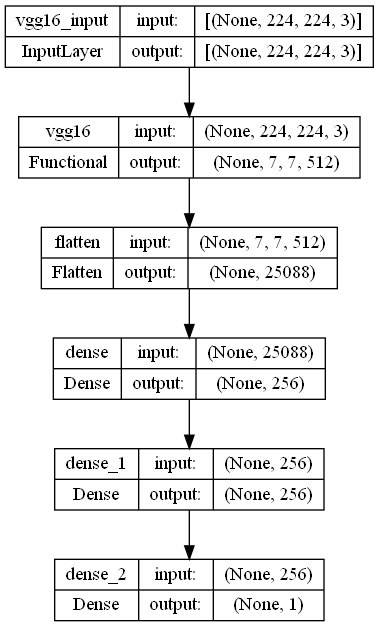

In [36]:
tf.keras.utils.plot_model(model, to_file='model_plot_VGG16.png', show_shapes=True, show_layer_names=True)

3.2 Train

In [37]:
logdir = "logs"

In [38]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [39]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])
# model.fit(): takes training date (dividie earlier in the code), epoches -> how many times we wnat to train our model 
# -> one epoch is runinng over entire training set of data
# the nwe pass our validation vlaues, so we can know how great performance has our model in real-time domain

Epoch 1/20
15/15 [==============================] - 53s 3s/step - loss: 1.2754 - accuracy: 0.5958 - val_loss: 0.4577 - val_accuracy: 0.8125
Epoch 2/20
15/15 [==============================] - 45s 3s/step - loss: 0.4079 - accuracy: 0.8125 - val_loss: 0.2924 - val_accuracy: 0.8500
Epoch 3/20
15/15 [==============================] - 63s 4s/step - loss: 0.2772 - accuracy: 0.8792 - val_loss: 0.3252 - val_accuracy: 0.8250
Epoch 4/20
15/15 [==============================] - 45s 3s/step - loss: 0.1808 - accuracy: 0.9375 - val_loss: 0.1480 - val_accuracy: 0.9250
Epoch 5/20
15/15 [==============================] - 45s 3s/step - loss: 0.1188 - accuracy: 0.9583 - val_loss: 0.1065 - val_accuracy: 0.9625
Epoch 6/20
15/15 [==============================] - 63s 4s/step - loss: 0.0597 - accuracy: 0.9875 - val_loss: 0.0711 - val_accuracy: 0.9625
Epoch 7/20
15/15 [==============================] - 45s 3s/step - loss: 0.0295 - accuracy: 1.0000 - val_loss: 0.0642 - val_accuracy: 0.9750
Epoch 8/20
15/15 [==

3.3 Plot Performance

In [40]:
hist.history

{'loss': [1.275422215461731,
  0.4078691303730011,
  0.2771708071231842,
  0.18083275854587555,
  0.11882779747247696,
  0.059677932411432266,
  0.029528219252824783,
  0.03519942983984947,
  0.02763870172202587,
  0.01836353912949562,
  0.012173982337117195,
  0.01410804782062769,
  0.03155533969402313,
  0.07212051749229431,
  0.01729799434542656,
  0.08736690133810043,
  0.13487820327281952,
  0.06670728325843811,
  0.024025805294513702,
  0.030761687085032463],
 'accuracy': [0.5958333611488342,
  0.8125,
  0.8791666626930237,
  0.9375,
  0.9583333134651184,
  0.987500011920929,
  1.0,
  0.987500011920929,
  0.9916666746139526,
  0.9958333373069763,
  1.0,
  0.9958333373069763,
  0.987500011920929,
  0.9708333611488342,
  1.0,
  0.9708333611488342,
  0.9416666626930237,
  0.9791666865348816,
  0.9916666746139526,
  0.9916666746139526],
 'val_loss': [0.4577488303184509,
  0.2923799753189087,
  0.32515013217926025,
  0.14799456298351288,
  0.10653769969940186,
  0.07113392651081085,
 

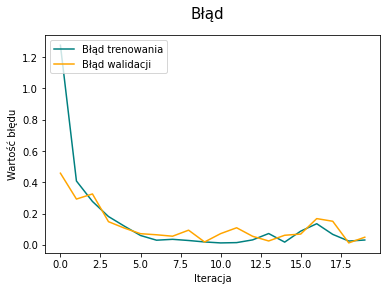

In [41]:
# Cause we saved information in hist variable, we cna now plot some interesting plots
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='Błąd trenowania')
plt.plot(hist.history['val_loss'], color='orange', label='Błąd walidacji')
fig.suptitle('Błąd', fontsize=15)
plt.xlabel('Iteracja', fontsize=10)
plt.ylabel('Wartość błędu', fontsize=10)
plt.legend(loc='upper left')
plt.show()

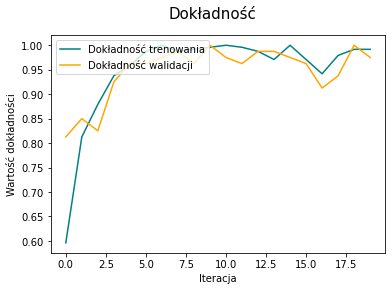

In [42]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='Dokładność trenowania')
plt.plot(hist.history['val_accuracy'], color='orange', label='Dokładność walidacji')
fig.suptitle('Dokładność', fontsize=15)
plt.xlabel('Iteracja', fontsize=10)
plt.ylabel('Wartość dokładności', fontsize=10)
plt.legend(loc='upper left')
plt.show()

4. Evaluate Performance

4.1 Evaluate

In [43]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [44]:
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

In [45]:
for batch in test.as_numpy_iterator():
    X, y = batch
    ythat = model.predict(X)
    precision.update_state(y, ythat)
    recall.update_state(y, ythat)
    accuracy.update_state(y, ythat)
    

1/1 [==============================] - 2s 2s/step


In [46]:
print(f'Precision: {precision.result().numpy()}, Recall: {recall.result().numpy()}, Accuracy: {accuracy.result().numpy()}')

Precision: 0.9655172228813171, Recall: 0.9655172228813171, Accuracy: 0.95652174949646


4.2 Test

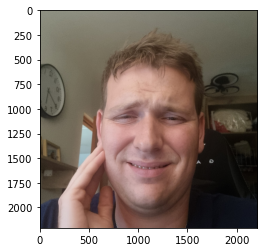

In [47]:
#img = cv2.imread('pain_test.JPG')
img = cv2.imread('test_Data/pain_test_v4.JPG')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

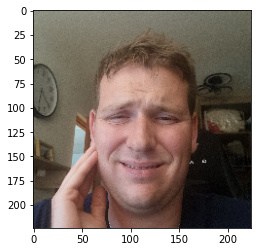

In [48]:
# We resized all batches of data to 256x256 size. The input data has to be the same size !!!
resize_img = tf.image.resize(img, (224,224))
plt.imshow(resize_img.numpy().astype(int))
plt.show()

In [49]:
yhat = model.predict(np.expand_dims(resize_img/255, 0)) 
# The model expect the batch of data not a single image, so we have to wrap data into batch (deeper into the list)

1/1 [==============================] - 1s 1s/step


In [50]:
yhat
#In this case 0 - happy, 1 - sad

array([[0.99872726]], dtype=float32)

In [51]:
if yhat < 0.5:
    print('We are Normal Normal People, Yuhu :) !!!')
else:
    print("Hello Pain My Old Friend :( ")

Hello Pain My Old Friend :( 


5. Save model

In [52]:
from tensorflow.keras.models import load_model
import os
import cv2
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np

In [53]:
#model.save(os.path.join('models', 'pain_detection_model_VGG16.h5'))

6. Reuse the model

In [54]:
new_model = load_model(os.path.join('models', 'pain_detection_model_VGG16.h5'))

In [55]:
input_img = cv2.imread('test_Data/WIN_20220901_20_17_59_Pro.jpg')
input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
plt.imshow(input_img)
plt.show()

error: OpenCV(4.6.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [ ]:
resized_img = tf.image.resize(input_img, (224,224))
plt.imshow(resized_img.numpy().astype(int))
plt.show()

In [ ]:
yhat_new = new_model.predict(np.expand_dims(resized_img/255, 0))

In [ ]:
yhat_new

In [ ]:
if yhat_new < 0.5:
    print('We are Normal Normal People, Yuhu :) !!!')
    plt.imshow(resized_img.numpy().astype(int))
else:
    print("Hello Pain My Old Friend :( ")
    plt.imshow(resized_img.numpy().astype(int))